In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


# Tiramisu / Camvid

Tiramisu can be found here https://arxiv.org/abs/1611.09326

It tries to fit an iamge to the label which is image the image itself but labelled with different colours for different objects such as sky, human, buildings etc.  An example is shown below with actual and label image

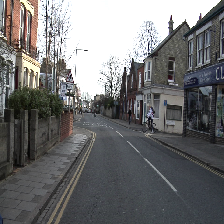

In [96]:
Image.open('camvid/701_StillsRaw_full/Seq05VD_f04740.png').resize((224,224), Image.NEAREST)

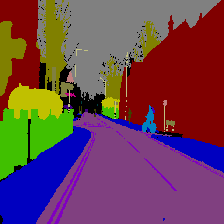

In [101]:
Image.open('camvid/LabeledApproved_full/Seq05VD_f04740_L.png').resize((224,224), Image.NEAREST)

## Setup

In [2]:
#PATH = 'SegNet-Tutorial/CamVid/'

In [3]:
#frames_path = PATH+'all/'

In [4]:
#labels_path = PATH+'allannot/'

In [5]:
PATH = 'camvid/'

In [6]:
frames_path = PATH+'701_StillsRaw_full/'

In [7]:
labels_path = PATH+'LabeledApproved_full/'

In [8]:
fnames = glob.glob(frames_path+'*.png')
print (fnames[0:3])

['camvid/701_StillsRaw_full/0006R0_f03660.png', 'camvid/701_StillsRaw_full/0016E5_05940.png', 'camvid/701_StillsRaw_full/Seq05VD_f00240.png']


In [9]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]
print (lnames[0:3])

['camvid/LabeledApproved_full/0006R0_f03660_L.png', 'camvid/LabeledApproved_full/0016E5_05940_L.png', 'camvid/LabeledApproved_full/Seq05VD_f00240_L.png']


In [10]:
#lnames = [labels_path+os.path.basename(fn) for fn in fnames]

In [11]:
img_sz = (480,360)

In [12]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [14]:
#def open_image(fn): return np.array(Image.open(fn))

In [11]:
img = Image.open(fnames[0])

In [ ]:
img

In [15]:
imgs = np.stack([open_image(fn) for fn in fnames])
imgs.shape

(701, 360, 480, 3)

In [16]:
labels = np.stack([open_image(fn) for fn in lnames])
labels.shape

(701, 360, 480, 3)

In [ ]:
imgs.shape,labels.shape

In [17]:
imgs = imgs/255.

In [17]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.39996644266360709, 0.30179491142291076)

In [20]:
imgs-=0.4
imgs/=0.3

In [18]:
save_array(PATH+'results/imgs2.bc', imgs)
save_array(PATH+'results/labels2.bc', labels)

In [11]:
imgs = load_array(PATH+'results/imgs2.bc')
labels = load_array(PATH+'results/labels2.bc')

In [13]:
# imgs = load_array(PATH+'results/imgs.bc')
# labels = load_array(PATH+'results/labels.bc')

In [14]:
n,r,c,ch = imgs.shape

## Preprocessing

### Generator

In [12]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [55]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [14]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([3, 4, 9]),
 array([6, 2, 7]),
 array([5, 1, 0]),
 array([8]),
 array([2, 1, 8])]

In [15]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

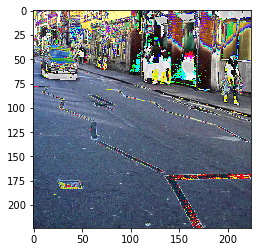

In [18]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[1]);

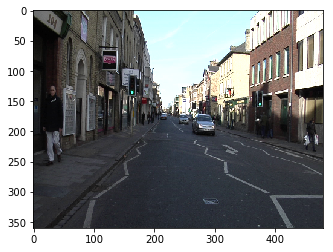

In [29]:
plt.imshow(imgs[1]*0.3+0.4);

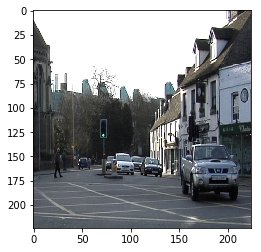

In [27]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

In [16]:
def parse_code(l):
    a,b = l.strip().split("\t")
    return tuple(int(o) for o in a.split(' ')), b

In [17]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            o=label_codes[a[j,k]]
            res[j,k] = o
    return res

In [18]:
label_codes,label_names = zip(*[parse_code(l) for l in open(PATH+"label_colors.txt")])

In [19]:
label_codes,label_names = list(label_codes),list(label_names)

In [20]:
hash = dict(zip(label_codes,label_names))

In [21]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [22]:
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

In [51]:
failed_code = len(label_codes)+1

In [40]:
# label_codes.append((0,0,0))
# label_names.append('unk')

In [45]:
n,r,c

(701, 360, 480)

In [44]:
labels.shape

(701, 360, 480, 3)

In [46]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = 30
    return res

In [47]:
from concurrent.futures import ProcessPoolExecutor

In [48]:
def conv_all_labels():
    ex = ProcessPoolExecutor(4)
    return np.stack(ex.map(conv_one_label, range(n)))

In [49]:
%time labels_int =conv_all_labels()

CPU times: user 476 ms, sys: 264 ms, total: 740 ms
Wall time: 6min 43s


In [ ]:
labels_int[labels_int==failed_code]=0

In [50]:
save_array(PATH+'results/labels_int.bc', labels_int)

In [23]:
labels_int = load_array(PATH+'results/labels_int.bc')

In [ ]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

In [ ]:
plt.imshow(color_label(np.resize(b_label[0], (224,224))));

In [64]:
labels_int[0,0,0]

21

In [27]:
labels_int.shape

(700, 360, 480)

In [24]:
hash[id2code[labels_int[0,359,479]]]

'Road'

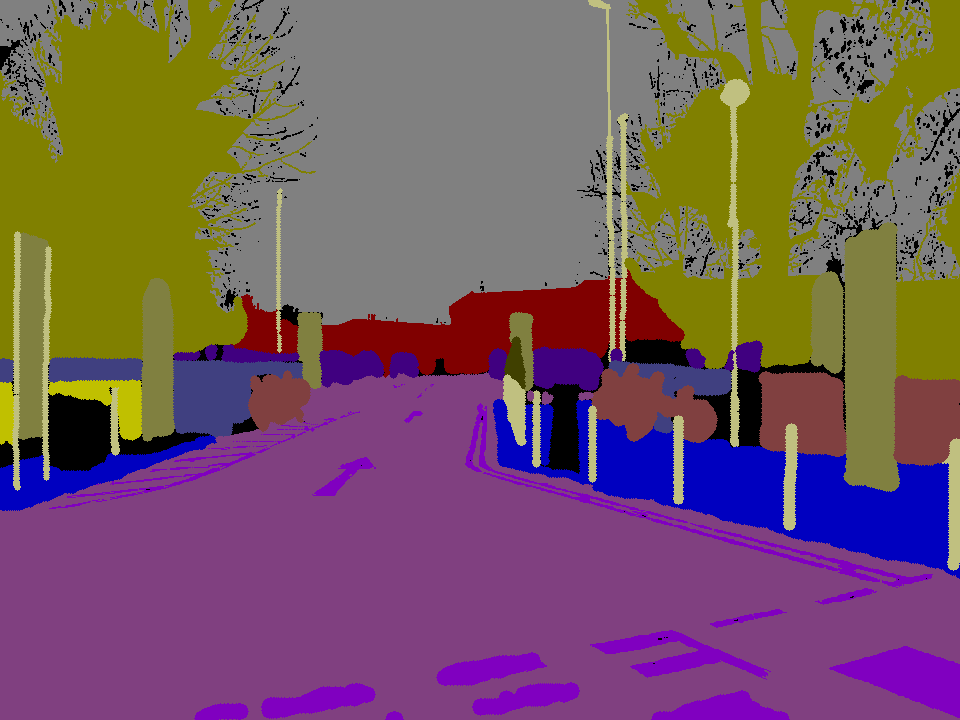

In [51]:
Image.open(lnames[0])

### Checking labels_int

In [28]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            o=label_codes[a[j,k]]
            res[j,k] = o
    return res

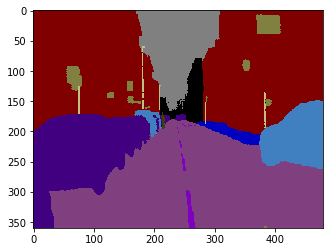

In [29]:
plt.imshow(color_label(train_labels[462]))

### Create Test

In [24]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [25]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

### Test set

In [ ]:
labels_int = labels

In [ ]:
fn_test = set(o.strip() for o in open(PATH+'test.txt','r'))

In [ ]:
is_test = np.array([o.split('/')[-1] in fn_test for o in fnames])

In [ ]:
trn = imgs[is_test==False]
trn_labels = labels_int[is_test==False]
test = imgs[is_test]
test_labels = labels_int[is_test]
trn.shape,test_labels.shape

In [ ]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

### The pieces

In [26]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [27]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [28]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [29]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [30]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [31]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [32]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [33]:
def reverse(a): return list(reversed(a))

In [34]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

In [35]:
lrg_sz = (224,224)

In [36]:
train_generator = segm_generator(train_set, train_labels, 3, out_sz=lrg_sz ,train=True)
test_generator = segm_generator(test_set, test_labels, 3, out_sz=lrg_sz, train=False)

In [37]:
input_shape = lrg_sz+(3,)
img_input = Input(shape=input_shape)

In [38]:
img_input = Input(shape=input_shape)

In [39]:
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [40]:
model = Model(img_input, x)

In [45]:
# gen = segm_generator(trn, trn_labels, 3, train=True)

In [46]:
# gen_test = segm_generator(test, test_labels, 3, train=False)

In [41]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [48]:
from keras_tqdm import TQDMNotebookCallback

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping =EarlyStopping(monitor='val_acc', patience=3)
bst_model_path = 'best_' + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [46]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [ ]:
model.fit_generator(train_generator, len(train_set), nb_epoch=100, verbose=2,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/100
233s - loss: 2.1718 - acc: 0.4911 - val_loss: 2.3761 - val_acc: 0.4643
Epoch 2/100
229s - loss: 1.4540 - acc: 0.6020 - val_loss: 1.8076 - val_acc: 0.6067
Epoch 5/100
229s - loss: 1.3971 - acc: 0.6163 - val_loss: 1.6472 - val_acc: 0.6322
Epoch 6/100
229s - loss: 1.3304 - acc: 0.6429 - val_loss: 1.7521 - val_acc: 0.5787
Epoch 7/100
229s - loss: 1.3123 - acc: 0.6518 - val_loss: 1.6020 - val_acc: 0.6118
Epoch 8/100
229s - loss: 1.2366 - acc: 0.6750 - val_loss: 1.5028 - val_acc: 0.6557
Epoch 9/100
229s - loss: 1.1873 - acc: 0.6896 - val_loss: 1.4715 - val_acc: 0.6546
Epoch 10/100
229s - loss: 1.1514 - acc: 0.7034 - val_loss: 1.5385 - val_acc: 0.6310
Epoch 11/100
229s - loss: 1.1338 - acc: 0.7049 - val_loss: 1.5494 - val_acc: 0.6136
Epoch 12/100
229s - loss: 1.0963 - acc: 0.7129 - val_loss: 1.3775 - val_acc: 0.6619
Epoch 13/100
229s - loss: 1.1016 - acc: 0.7111 - val_loss: 1.4908 - val_acc: 0.6415
Epoch 14/100
229s - loss: 1.0821 - acc: 0.7212 - val_loss: 1.4775 - val_acc: 0.6428

In [ ]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), nb_epoch=200, verbose=2,
                    validation_data=test_generator, nb_val_samples=len(test_set))

In [53]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), nb_epoch=200, verbose=2,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/200
228s - loss: 0.6408 - acc: 0.8454 - val_loss: 0.8016 - val_acc: 0.8059
Epoch 2/200
227s - loss: 0.6584 - acc: 0.8431 - val_loss: 0.8822 - val_acc: 0.7887
Epoch 3/200
227s - loss: 0.6627 - acc: 0.8414 - val_loss: 0.7806 - val_acc: 0.8231
Epoch 4/200
227s - loss: 0.6529 - acc: 0.8418 - val_loss: 0.7463 - val_acc: 0.8286
Epoch 5/200
227s - loss: 0.6408 - acc: 0.8456 - val_loss: 1.0880 - val_acc: 0.7282
Epoch 6/200
227s - loss: 0.6366 - acc: 0.8463 - val_loss: 0.7960 - val_acc: 0.8232
Epoch 7/200
227s - loss: 0.6607 - acc: 0.8408 - val_loss: 0.9555 - val_acc: 0.7508
Epoch 8/200
227s - loss: 0.6532 - acc: 0.8438 - val_loss: 0.7783 - val_acc: 0.8198
Epoch 9/200
227s - loss: 0.6480 - acc: 0.8424 - val_loss: 0.7660 - val_acc: 0.8170
Epoch 10/200
227s - loss: 0.6368 - acc: 0.8478 - val_loss: 0.8304 - val_acc: 0.8172
Epoch 11/200
227s - loss: 0.6270 - acc: 0.8507 - val_loss: 0.7430 - val_acc: 0.8298
Epoch 12/200
227s - loss: 0.6411 - acc: 0.8454 - val_loss: 0.7828 - val_acc: 0.8231
E

In [56]:
model.save_weights('final_1.h5')

## Test

### Actual Image

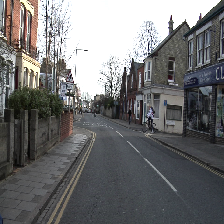

In [96]:
Image.open('camvid/701_StillsRaw_full/Seq05VD_f04740.png').resize((224,224), Image.NEAREST)

In [97]:
try_image = np.array(Image.open('camvid/701_StillsRaw_full/Seq05VD_f04740.png').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=.4
try_image/=3
try_image.shape

(224, 224, 3)

In [98]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)

In [99]:
try_preds = np.argmax(try_preds, axis=-1)

### Prediction

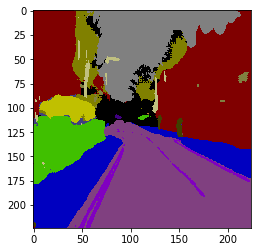

In [100]:
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))

### Actual Target

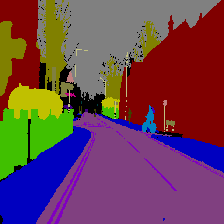

In [101]:
Image.open('camvid/LabeledApproved_full/Seq05VD_f04740_L.png').resize((224,224), Image.NEAREST)